In [1]:
import pandas as pd
import glob
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
import pyarrow.parquet as pq

def read_parquet_rowgroups(path):
    pf = pq.ParquetFile(path)
    dfs = []
    for i in range(pf.num_row_groups):
        table = pf.read_row_group(i)
        df = table.to_pandas()
        df["symbol"] = df["symbol"].astype(str)
        df["date"] = df["date"].astype(str)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

In [3]:
def load_all_ohlc(symbol="BTCUSD"):
    pattern = f"../../data/outputs/ohlc/symbol={symbol}/date=*/*.parquet"
    files = glob.glob(pattern, recursive=True)

    if not files:
        raise FileNotFoundError(f"No parquet files found at {pattern}")

    dfs = []
    for f in files:
        dfs.append(read_parquet_rowgroups(f))

    df = pd.concat(dfs, ignore_index=True)
    return df.sort_values("timestamp")

In [4]:
df_btc = load_all_ohlc("BTCUSD")
df_eth = load_all_ohlc("ETHUSD")
df_usdt = load_all_ohlc("USDTUSD")

In [5]:
def add_trend_label(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add 'trend' column:
      1 if next close > current close (UP)
      0 otherwise (DOWN or FLAT)
    """
    df = df.copy()
    df["future_close"] = df["close"].shift(-1)
    df["trend"] = (df["future_close"] > df["close"]).astype(int)
    df = df.dropna(subset=["future_close", "trend"])
    return df


In [6]:
def add_trend_label(df):
    df = df.copy()
    df["future_close"] = df["close"].shift(-1)
    df["trend"] = (df["future_close"] > df["close"]).astype(int)
    return df.dropna(subset=["future_close"])


In [7]:
def add_features(df):
    df = df.copy()
    df = df.sort_values("timestamp")

    # Momentum
    df["return_1"] = df["close"].pct_change()

    # Trend (moving averages)
    df["ma_5"] = df["close"].rolling(5).mean()
    df["ma_10"] = df["close"].rolling(10).mean()

    # Volatility
    df["vol_5"] = df["return_1"].rolling(5).std()
    df["vol_10"] = df["return_1"].rolling(10).std()

    # Range
    df["range"] = df["high"] - df["low"]

    df = df.dropna(subset=["return_1", "ma_5", "ma_10", "vol_5", "vol_10", "range"])
    return df


In [8]:
FEATURE_COLUMNS = ["return_1", "ma_5", "ma_10", "vol_5", "vol_10", "range"]

def train_for_symbol(df, symbol):
    print(f"\n=== Training model for {symbol} ===")

    df["datetime"] = pd.to_datetime(df["timestamp"], unit="ms")

    df = add_trend_label(df)
    df = add_features(df)
    
    X = df[FEATURE_COLUMNS].values
    y = df["trend"].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    model = SGDClassifier(
        loss="log_loss",
        penalty="l2",
        alpha=1e-3,
        learning_rate="optimal",
        max_iter=1000000000,
        tol=1e-5,
        random_state=42,
    )

    model.fit(X_train, y_train)

    # Test accuracy
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{symbol} accuracy: {acc:.4f}")

    return df, scaler, model


In [9]:
df_btc, scaler_btc, model_btc = train_for_symbol(df_btc, "BTCUSD")
df_eth, scaler_eth, model_eth = train_for_symbol(df_eth, "ETHUSD")
df_usdt, scaler_usdt, model_usdt = train_for_symbol(df_usdt, "USDTUSD")


=== Training model for BTCUSD ===
BTCUSD accuracy: 0.6244

=== Training model for ETHUSD ===
ETHUSD accuracy: 0.7352

=== Training model for USDTUSD ===
USDTUSD accuracy: 0.8333


In [10]:
def graph_trends(df, symbol):
    plt.figure(figsize=(14,6))
    plt.plot(df["datetime"], df["close"], label="Close Price", linewidth=1)
    plt.plot(df["datetime"], df["ma_5"], label="MA 5")
    plt.plot(df["datetime"], df["ma_10"], label="MA 10")

    plt.title(f"Price with Moving Averages for {symbol}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

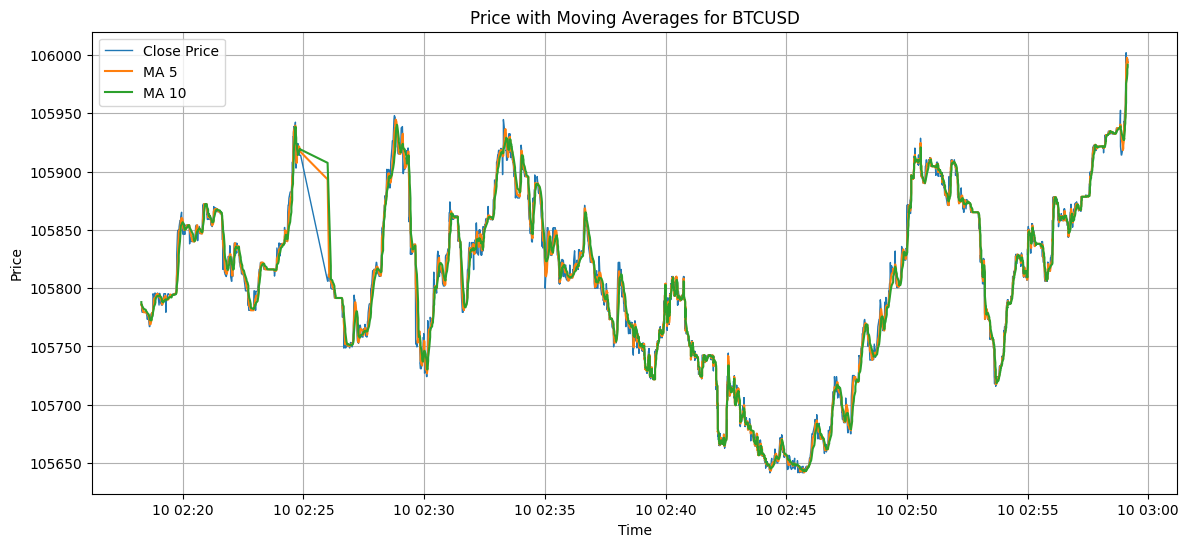

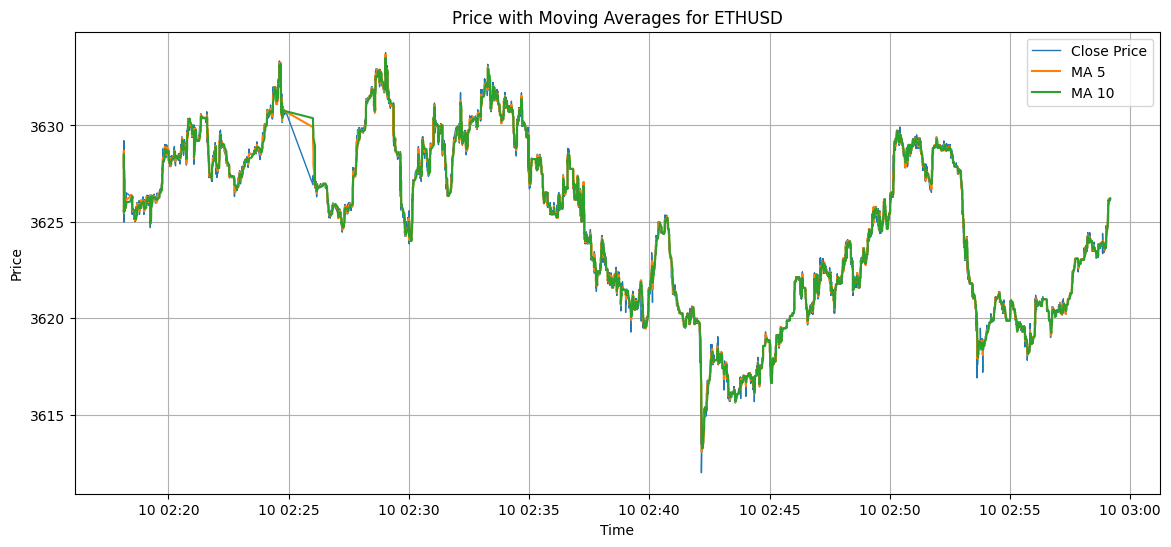

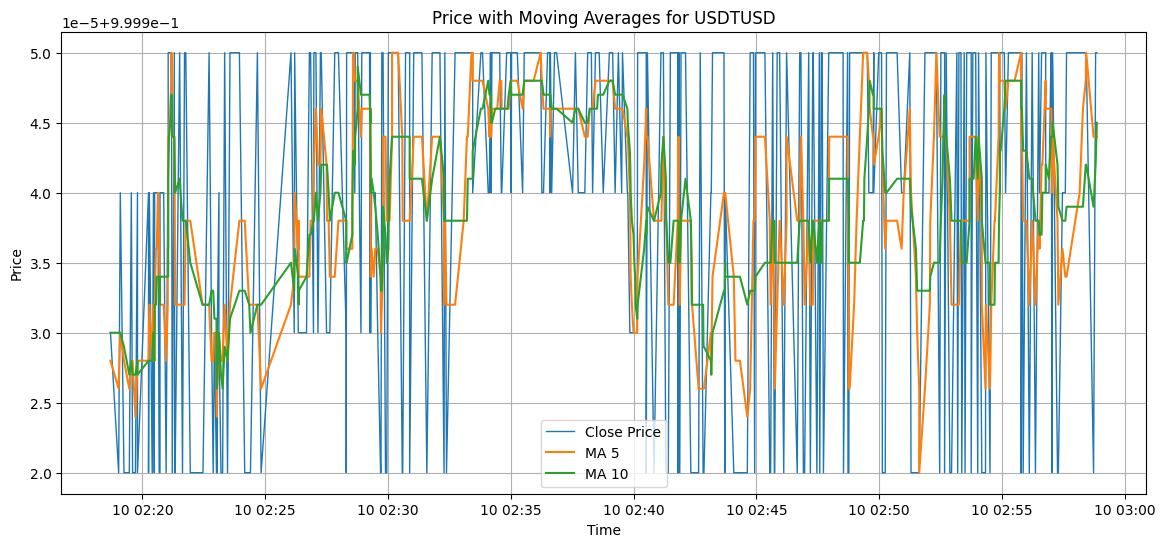

In [11]:
graph_trends(df_btc, "BTCUSD")
graph_trends(df_eth, "ETHUSD")
graph_trends(df_usdt, "USDTUSD")

In [12]:
def graph_volatility(df, symbol):
    plt.figure(figsize=(14,6))
    plt.plot(df["datetime"], df["return_1"], label="Return 1", alpha=0.7)
    plt.plot(df["datetime"], df["vol_5"], label="Vol 5", alpha=0.7)
    plt.plot(df["datetime"], df["vol_10"], label="Vol 10", alpha=0.7)

    plt.title(f"Returns and Volatility Over Time for {symbol}")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()


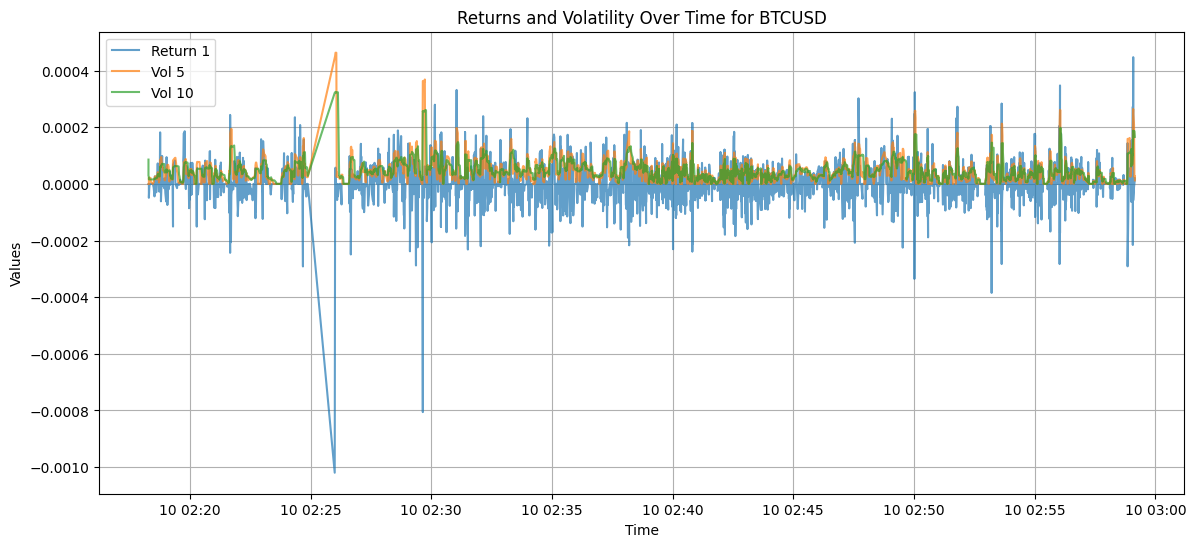

In [13]:
graph_volatility(df_btc, "BTCUSD")

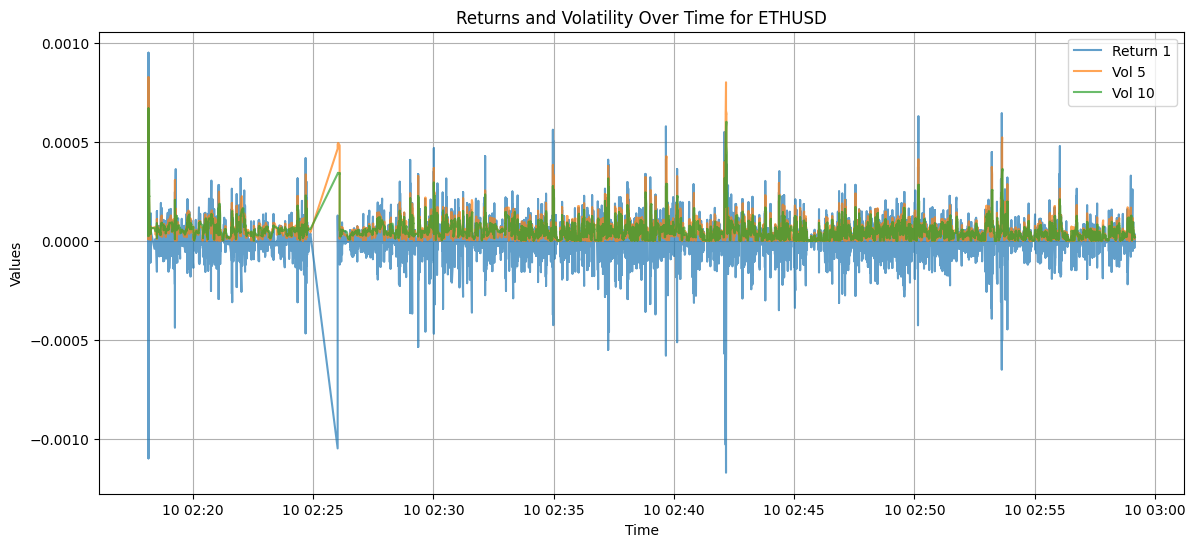

In [14]:
graph_volatility(df_eth, "ETHUSD")

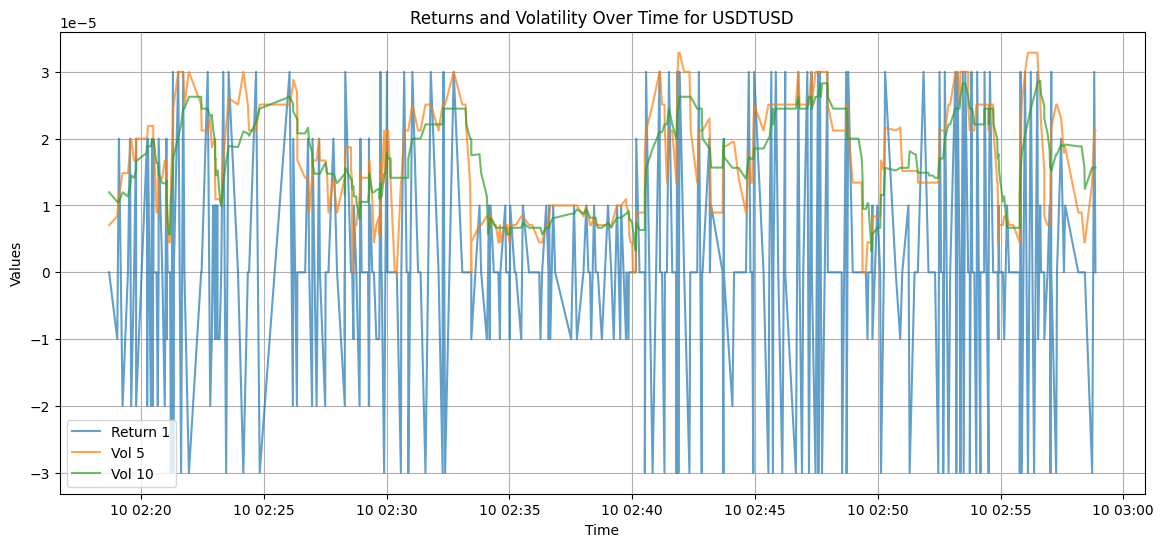

In [15]:
graph_volatility(df_usdt, "USDTUSD")

In [16]:
# Compute predictions on full dataset

def graph_predicted_trend(df, scaler, model):
    X_scaled = scaler.transform(df[FEATURE_COLUMNS])
    df["pred"] = model.predict(X_scaled)

    plt.figure(figsize=(14,4))
    plt.plot(df["datetime"], df["trend"], label="Actual Trend", alpha=0.7)
    plt.plot(df["datetime"], df["pred"], label="Predicted Trend", alpha=0.7)

    plt.title("Predicted Trend vs Actual Trend")
    plt.xlabel("Time")
    plt.ylabel("Trend (1=Up, 0=Down)")
    plt.legend()
    plt.grid(True)
    plt.show()


/Users/raunakbandyopadhyay/py_envs/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


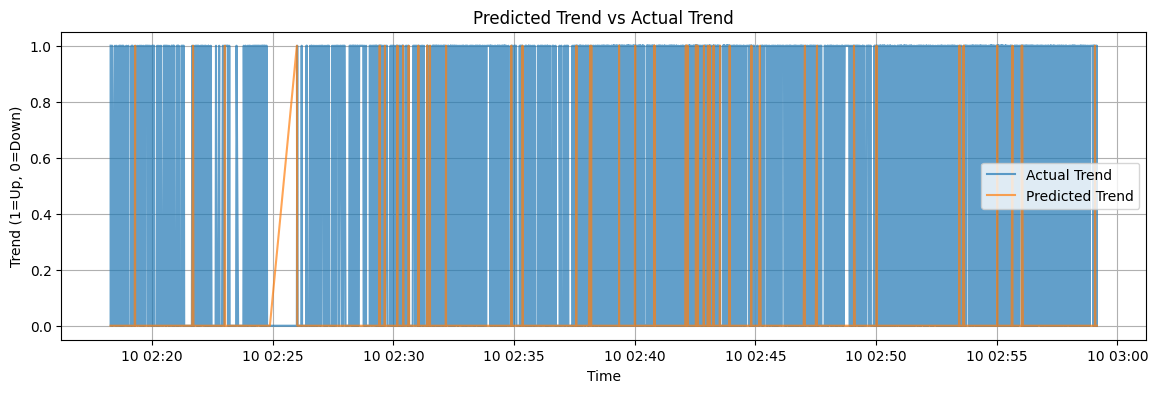

/Users/raunakbandyopadhyay/py_envs/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


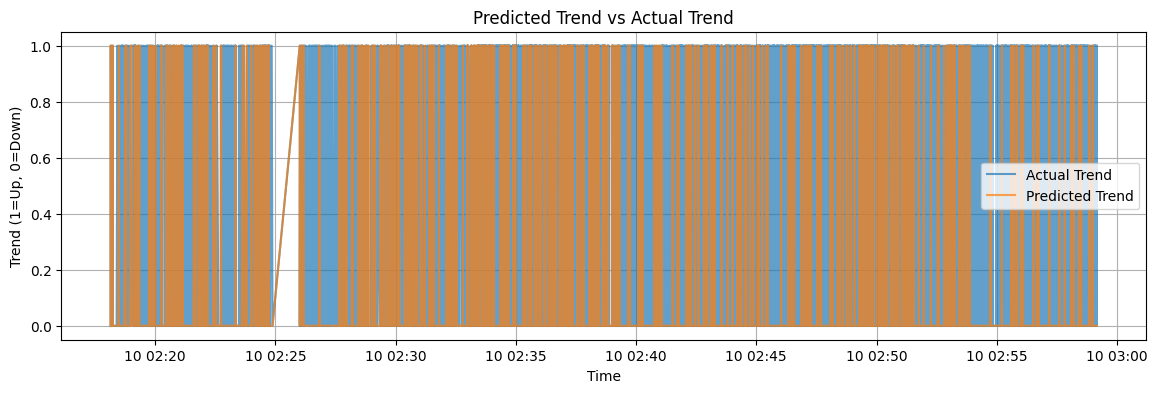

/Users/raunakbandyopadhyay/py_envs/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


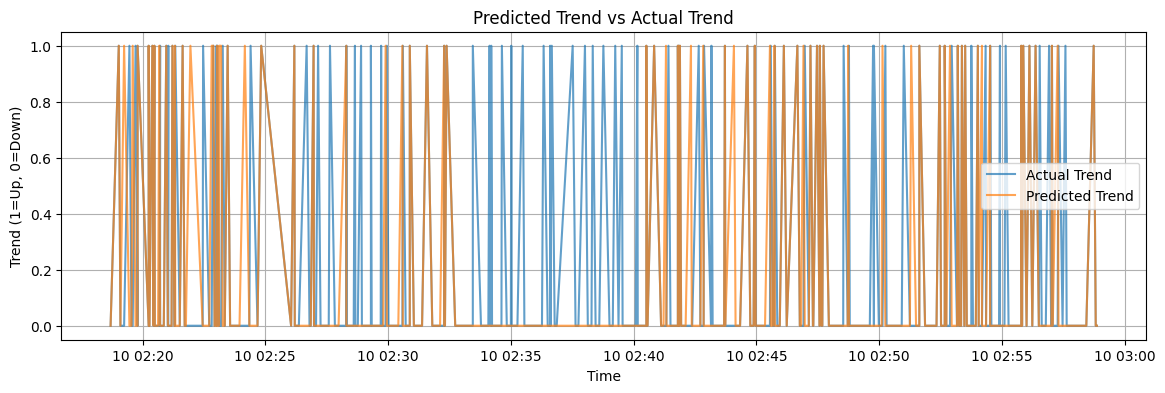

In [17]:
graph_predicted_trend(df_btc, scaler_btc, model_btc)
graph_predicted_trend(df_eth, scaler_eth, model_eth)
graph_predicted_trend(df_usdt, scaler_usdt, model_usdt)

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cnf_mtx(df, symbol):
    cm = confusion_matrix(df["trend"], df["pred"])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Down","Up"],
                yticklabels=["Down","Up"])
    plt.title(f"Confusion Matrix for {symbol}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


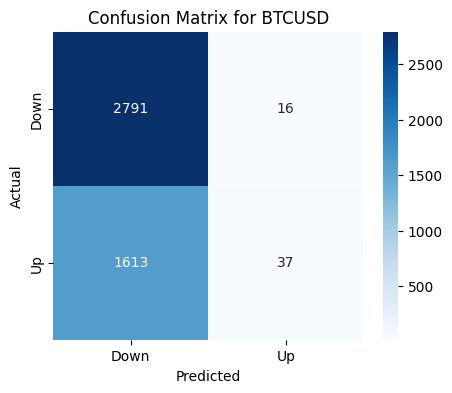

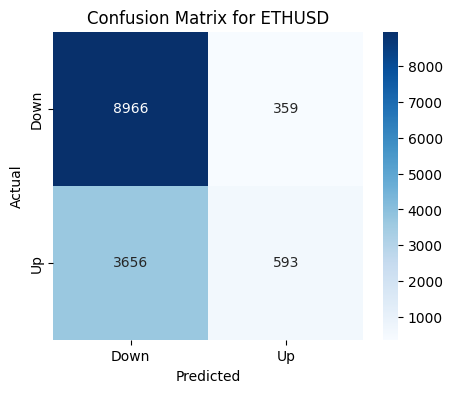

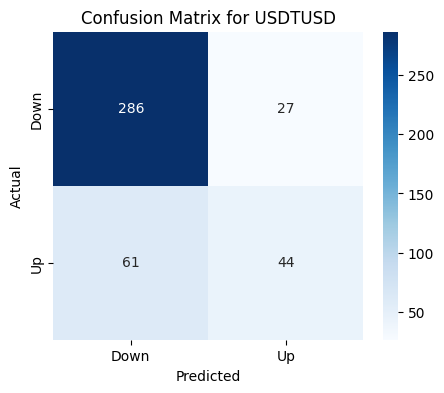

In [19]:
plot_cnf_mtx(df_btc, "BTCUSD")
plot_cnf_mtx(df_eth, "ETHUSD")
plot_cnf_mtx(df_usdt, "USDTUSD")